In [1]:
import pandas as pd

# Load the dataset, parsing the 'date' column as dates
exchange_rate = pd.read_csv('exchange_rate.csv', parse_dates=['date'])

# Display some info to check the data
exchange_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


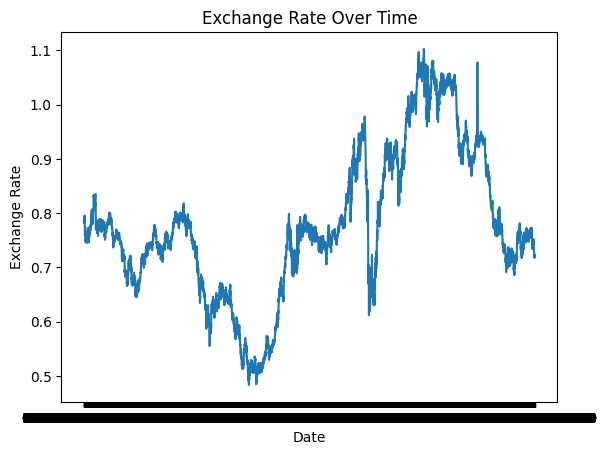

In [3]:
import matplotlib.pyplot as plt

# Assuming 'currency_column_name' is the name of your currency column
plt.plot(exchange_rate['date'], exchange_rate['Ex_rate'])
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.show()

In [6]:
# Handling missing values
exchange_rate['Ex_rate'].fillna(method='ffill', inplace=True)

# Handling anomalies (example - remove outliers using IQR)
Q1 = exchange_rate['Ex_rate'].quantile(0.25)
Q3 = exchange_rate['Ex_rate'].quantile(0.75)
IQR = Q3 - Q1
exchange_rate = exchange_rate[~((exchange_rate['Ex_rate'] < (Q1 - 1.5 * IQR)) | (exchange_rate['Ex_rate'] > (Q3 + 1.5 * IQR)))]

<ipython-input-6-8b93971a54e2>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  exchange_rate['Ex_rate'].fillna(method='ffill', inplace=True)
<ipython-input-6-8b93971a54e2>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exchange_rate['Ex_rate'].fillna(method='ffill', inplace=True)


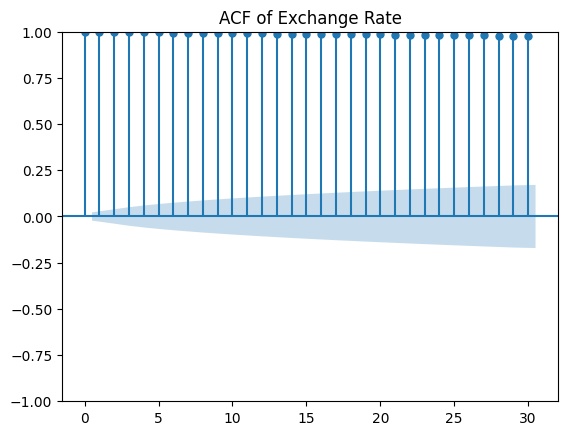

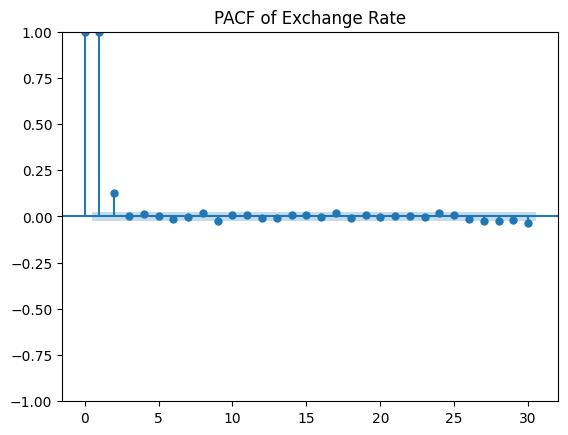

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'Ex_rate' is the column with exchange rate values
# and the data is already loaded in the 'exchange_rate' DataFrame

# Calculate and plot ACF
plot_acf(exchange_rate['Ex_rate'], lags=30)  # Adjust lags as needed
plt.title('ACF of Exchange Rate')
plt.show()

# Calculate and plot PACF
plot_pacf(exchange_rate['Ex_rate'], lags=30)  # Adjust lags as needed
plt.title('PACF of Exchange Rate')
plt.show()

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming you've determined p, d, q from the ACF/PACF plots
# Example: p=2, d=1, q=1
model = ARIMA(exchange_rate['Ex_rate'], order=(2, 1, 1))
model_fit = model.fit()

# Print model summary to see the estimated coefficients and other statistics
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(2, 1, 1)   Log Likelihood               28054.157
Date:                Mon, 18 Nov 2024   AIC                         -56100.315
Time:                        09:32:12   BIC                         -56072.578
Sample:                             0   HQIC                        -56090.796
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0655      0.001    -60.736      0.000      -0.068      -0.063
ar.L2          0.0084      0.006      1.422      0.155      -0.003       0.020
ma.L1         -0.0661      0.001    -59.596      0.0

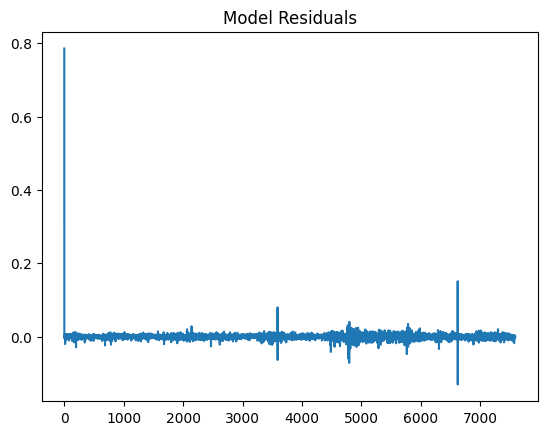

In [9]:
# Plot the residuals
residuals = model_fit.resid
plt.plot(residuals)
plt.title('Model Residuals')
plt.show()

# You can also perform statistical tests on the residuals,
# such as the Ljung-Box test for autocorrelation.

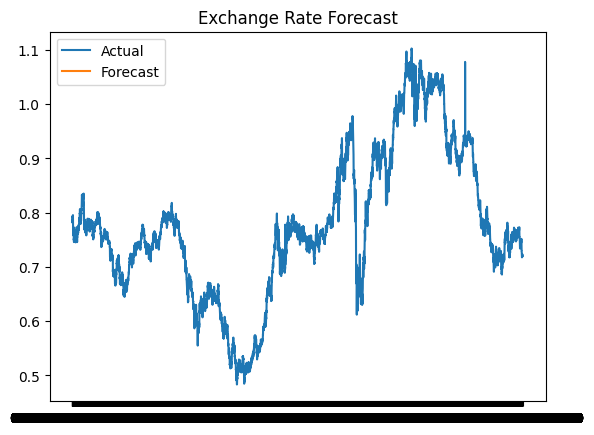

In [10]:
# Forecast the next 'n' periods (e.g., n=10)
forecast = model_fit.predict(start=len(exchange_rate), end=len(exchange_rate) + 9)

# Plot the forecast against the actual values (if available)
plt.plot(exchange_rate['date'], exchange_rate['Ex_rate'], label='Actual')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title('Exchange Rate Forecast')
plt.show()

In [13]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error


# Define parameter grid for grid search
param_grid = {
    'smoothing_level': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'smoothing_slope': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'damping_slope': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    # Add 'seasonal_periods' if using Holt-Winters
}

# Perform grid search to find optimal parameters
best_mse = float('inf')
best_params = {}

for params in ParameterGrid(param_grid):
    model = ExponentialSmoothing(
        exchange_rate['Ex_rate'],
        trend='add',  # Use 'add' or 'mul' based on your data
        # seasonal='add',  # If using Holt-Winters, specify seasonal type and periods
        # ... (other parameters) ...
    ).fit(**params)

    # Calculate MSE on training data
    mse = mean_squared_error(exchange_rate['Ex_rate'], model.fittedvalues)

    if mse < best_mse:
        best_mse = mse
        best_params = params

# Fit the model with the best parameters
best_model = ExponentialSmoothing(
    exchange_rate['Ex_rate'],
    trend='add',
).fit(**best_params)

# Make forecasts
forecast = best_model.forecast(10)  # Forecast the next 10 periods



<ipython-input-13-9d3442ec8327>:20: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: FutureWarning: the 'damping_slope' keyword is deprecated, use 'damping_trend' instead.
  return func(*args, **kwargs)
<ipython-input-13-9d3442ec8327>:20: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: FutureWarning: the 'damping_slope' keyword is deprecated, use 'damping_trend' instead.
  return func(*args, **kwargs)
<ipython-input-13-9d3442ec8327>:20: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model = ExponentialSmoothing(
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: FutureWarning: the 'damping_slope' keyword is deprecated, use 'damping_

In [16]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    return mae, rmse, mape

# Assuming 'forecast_arima' and 'forecast_holtwinters'

actual_values = exchange_rate['Ex_rate'].tail(10).values # Extract actual values for comparison


forecast_arima = forecast # Replace with your ARIMA forecast values
forecast_holtwinters = forecast # Replace with your Holt-Winters forecast values

mae_arima, rmse_arima, mape_arima = evaluate_model(actual_values, forecast_arima)
mae_holtwinters, rmse_holtwinters, mape_holtwinters = evaluate_model(actual_values, forecast_holtwinters)

print("ARIMA - MAE:", mae_arima, "RMSE:", rmse_arima, "MAPE:", mape_arima)
print("Holt-Winters - MAE:", mae_holtwinters, "RMSE:", rmse_holtwinters, "MAPE:", mape_holtwinters)

ARIMA - MAE: 0.002705073764538457 RMSE: 0.003535590967444678 MAPE: 0.3751516295668301
Holt-Winters - MAE: 0.002705073764538457 RMSE: 0.003535590967444678 MAPE: 0.3751516295668301
